In [1]:
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import fuzzy_classification as fc

In [2]:
traindata_df = fc.traindata_df
target_df = fc.target_df

In [3]:
# To stop potential randomness
seed = 50
rng = np.random.RandomState(seed)
#print ('rng : ', rng)

In [4]:
random_seed = 25
train_x = traindata_df.values
target_y = target_df.values

#split_size = int(train_x.shape[0] * 0.7)
train_x, val_x, target_y, val_y = train_test_split(
        train_x, target_y, test_size=0.33, random_state=random_seed)

train_xx, val_xx, target_yy, val_yy = train_test_split(
        train_x, target_y, test_size=0.33, random_state=random_seed)

is_equalv = np.array_equiv(val_y, val_yy)
print (is_equalv)
"""
train_x, val_x = train_x[: split_size], train_x[split_size : ]
target_y, val_y = target_y[: split_size], target_y[split_size : ]

print ('Train_x.shape : ', train_x.shape, "val_x.shape : ", val_x.shape)
print ('target_y.shape : ', target_y.shape, "val_y.shape : ", val_y.shape)
"""

False


'\ntrain_x, val_x = train_x[: split_size], train_x[split_size : ]\ntarget_y, val_y = target_y[: split_size], target_y[split_size : ]\n\nprint (\'Train_x.shape : \', train_x.shape, "val_x.shape : ", val_x.shape)\nprint (\'target_y.shape : \', target_y.shape, "val_y.shape : ", val_y.shape)\n'

In [5]:
def dense_to_one_hot(labels_dense, num_classes=11):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    #print ('num_labels : ', num_labels)
    index_offset = np.arange(num_labels) * num_classes
    #print ('index_offset : ', index_offset)
    #print ('index_offset->shape : ', index_offset.shape)
    labels_one_hot = np.zeros((num_labels, num_classes))
    #print ('1st labels_one_hot : ', labels_one_hot)
    #print ('1st labels_one_hot->shape : ', labels_one_hot.shape)
    #print ('labels_dense.ravel() : ', labels_dense.ravel())
    #print ('index_offset + labels_dense.ravel() : ', index_offset + labels_dense.ravel())
    labels_one_hot.flat[index_offset.astype(int) + labels_dense.ravel().astype(int)] = 1
    #print ('flat : ', labels_one_hot.flat[99])
    #print ('2nd labels_one_hot : ', labels_one_hot)
    #print ('2nd labels_one_hot->shape : ', labels_one_hot.shape)
    
    return labels_one_hot

In [6]:
def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    #print ('unclean_batch_x : ', unclean_batch_x)
    #print ('unclean_batch_x->shape : ', unclean_batch_x.shape)
    #print ('unclean_batch_x.max() : ', unclean_batch_x.max())
    #temp_batch = unclean_batch_x / unclean_batch_x.max()
    temp_batch = unclean_batch_x
    #print ('temp_batch : ', temp_batch)
    #print ('temp_batch->shape : ', temp_batch.shape)
    
    return temp_batch

In [7]:
def batch_creator(batch_size, dataset_length, step_name):
    """Create batch with random samples and return appropriate format"""
    #print ('batch_size : ', batch_size)
    #print ('dataset_length : ', dataset_length)
    
    batch_mask = rng.choice(dataset_length, batch_size)
    #print ('batch_mask : ', batch_mask)
    #print ('batch_mask->shape : ', batch_mask.shape)
    
    batch_x = train_x[[batch_mask]].reshape(-1, 28)
    #print ('eval(dataset_name + _x)[[batch_mask]] : ', eval(dataset_name + '_x')[[batch_mask]])
    #print ('eval(dataset_name + _x)[[batch_mask]]->shape : ', eval(dataset_name + '_x')[[batch_mask]].shape)

    #print ('batch_x : ', batch_x)
    #print ('batch_x->shape : ', batch_x.shape)
    
    batch_x = preproc(batch_x)
    #print ('batch_x after preproc : ', batch_x)
    #print ('batch_x after preproc->shape : ', batch_x.shape)
    
    if step_name == 'train':
        batch_y = target_y[batch_mask]
        #print ('batch_y : ', batch_y)
        #print ('batch_y->shape : ', batch_y.shape)
        batch_y = dense_to_one_hot(batch_y)
        #print ('batch_y after one-hot : ', batch_y)
        #print ('batch_y after one-hot->shape : ', batch_y.shape)
        
    return batch_x, batch_y

In [8]:
batch_size = 50
batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
print (batch_x.shape)
print (batch_y.shape)

(50, 28)
(50, 11)


In [9]:
### set all variables

# number of neurons in each layer
input_num_units = 28
n_units_hl1 = 500
n_units_hl2 = 500
n_units_hl3 = 500
n_units_hl4 = 500
n_units_hl5 = 500
n_units_hl6 = 500
n_units_hl7 = 500

n_classes = 11
output_num_units = 11
learning_rate = 0.01

# define placeholders
x = tf.placeholder('float', [None, input_num_units])
y = tf.placeholder('float', [None, output_num_units])
keep_prob = tf.placeholder('float')
# set remaining variables
epochs = 7
batch_size = 50

### define weights and biases of the neural network

weights = {
    'hidden_1' : tf.Variable(tf.random_normal([input_num_units, n_units_hl1], seed=seed)),
    'hidden_2' : tf.Variable(tf.random_normal([n_units_hl1, n_units_hl2], seed=seed)),
    'hidden_3' : tf.Variable(tf.random_normal([n_units_hl2, n_units_hl3], seed=seed)),
    'hidden_4' : tf.Variable(tf.random_normal([n_units_hl3, n_units_hl4], seed=seed)),
    'hidden_5' : tf.Variable(tf.random_normal([n_units_hl4, n_units_hl5], seed=seed)),
    'hidden_6' : tf.Variable(tf.random_normal([n_units_hl5, n_units_hl6], seed=seed)),
    'hidden_7' : tf.Variable(tf.random_normal([n_units_hl6, n_units_hl7], seed=seed)),
    ######## for  Hidden Layer
    'output' : tf.Variable(tf.random_normal([n_units_hl2, output_num_units], seed=seed))
}

biases = {
    'hidden_1' : tf.Variable(tf.random_normal([n_units_hl1], seed=seed)),
    'hidden_2' : tf.Variable(tf.random_normal([n_units_hl2], seed=seed)),
    'hidden_3' : tf.Variable(tf.random_normal([n_units_hl3], seed=seed)),
    'hidden_4' : tf.Variable(tf.random_normal([n_units_hl4], seed=seed)),
    'hidden_5' : tf.Variable(tf.random_normal([n_units_hl5], seed=seed)),
    'hidden_6' : tf.Variable(tf.random_normal([n_units_hl6], seed=seed)),
    'hidden_7' : tf.Variable(tf.random_normal([n_units_hl7], seed=seed)),

    'output' : tf.Variable(tf.random_normal([output_num_units], seed=seed))
}

In [10]:
### create neural network computational graph

hidden_layer_1 = tf.add(tf.matmul(x, weights['hidden_1']), biases['hidden_1'])
hidden_layer_1 = tf.nn.relu(hidden_layer_1)
hidden_layer_1 = tf.nn.dropout(hidden_layer_1, keep_prob)

hidden_layer_2 = tf.add(tf.matmul(hidden_layer_1, weights['hidden_2']), biases['hidden_2'])
hidden_layer_2 = tf.nn.relu(hidden_layer_2)
hidden_layer_2 = tf.nn.dropout(hidden_layer_2, keep_prob)

"""
hidden_layer_3 = tf.add(tf.matmul(hidden_layer_2, weights['hidden_3']), biases['hidden_3'])
hidden_layer_3 = tf.nn.relu(hidden_layer_3)
hidden_layer_3 = tf.nn.dropout(hidden_layer_3, keep_prob)

hidden_layer_4 = tf.add(tf.matmul(hidden_layer_3, weights['hidden_4']), biases['hidden_4'])
hidden_layer_4 = tf.nn.relu(hidden_layer_4)
hidden_layer_4 = tf.nn.dropout(hidden_layer_4, keep_prob)


hidden_layer_5 = tf.add(tf.matmul(hidden_layer_4, weights['hidden_5']), biases['hidden_5'])
hidden_layer_5 = tf.nn.relu(hidden_layer_5)
hidden_layer_5 = tf.nn.dropout(hidden_layer_5, keep_prob)

hidden_layer_6 = tf.add(tf.matmul(hidden_layer_5, weights['hidden_6']), biases['hidden_6'])
hidden_layer_6 = tf.nn.relu(hidden_layer_6)
hidden_layer_6 = tf.nn.dropout(hidden_layer_6, keep_prob)


hidden_layer_7 = tf.add(tf.matmul(hidden_layer_6, weights['hidden_7']), biases['hidden_7'])
hidden_layer_7 = tf.nn.relu(hidden_layer_7)
hidden_layer_7 = tf.nn.dropout(hidden_layer_7, keep_prob)

"""
### for 7 Hidden layer
output_layer = tf.matmul(hidden_layer_2, weights['output']) + biases['output']


In [11]:
### cost of neural network

#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output_layer, y))
### set optimizer. i.e backpropagation algorithm

#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
## after defining neural network. initialize all the variables.

#init = tf.initialize_all_variables()

In [16]:
last_epoch_cost = np.array([])
acc = np.array([])
for k in range(0, 5):
    train_x, val_x, target_y, val_y = train_test_split(
        train_x, target_y, test_size=0.33, random_state=random_seed)
    
    cost = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                logits=output_layer, labels=y)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        # create initialized variables.
        sess.run(init)

        ### for each epoch, do:
        ###    for each batch, do:
        ###        create pre-processed batch
        ###        run optimizer by feed batch
        ###        find cost and reiterate to minimize

        for epoch in range(epochs):
            avg_cost = 0
            total_batch = int(traindata_df.shape[0] / batch_size)
            for i in range(total_batch):
                batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
                _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y, keep_prob: 0.75})

                avg_cost += c / total_batch
                #print ('_ : ', _)
            #print ("Epoch : ", (epoch+1), "cost : ", "{:.5f}".format(avg_cost))
        
        last_epoch_cost = np.append(last_epoch_cost, avg_cost)
        #print ("\nTraining Complete!")
        # Find prediction on val set
        pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
        #print ('tf.argmax(output_layer, 1) : ', tf.argmax(output_layer, 1))
        #print (' tf,argmax(y, 1) : ',  tf.argmax(y, 1))
        #print ('pred_temp : ', pred_temp)

        accuracy = tf.reduce_mean(tf.cast(pred_temp, 'float'))
        #print ("Validation Accuarcy : ", accuracy.eval({x: val_x.reshape(-1, 784), y: dense_to_one_hot(val_y)}))

        feed_dict = {x: val_x.reshape(-1, 28), y: dense_to_one_hot(val_y), keep_prob: 1}
        
        val_acc = sess.run(accuracy,feed_dict)
        acc = np.append(acc, val_acc)
        #print ("Validation Accuarcy : ", sess.run(accuracy,feed_dict))

        #predict = tf.argmax(output_layer, 1)
        #pred = predict.eval({x: test.reshape(-1, 784)})

        predict = tf.argmax(output_layer, 1)
        # pred = predict.eval({x: test.reshape(-1, 784)})
        feed_dict = {x: val_x.reshape(-1, 28), keep_prob : 1}
        classification = sess.run(predict, feed_dict)
        #print ("Classification : ", classification)
print ('last_epoch_cost :')
print (last_epoch_cost)
print ('accuracy :')
print (acc)
print ('Average score : ', np.average(acc))

InternalError: Blas GEMM launch failed : a.shape=(50, 28), b.shape=(28, 500), m=50, n=500, k=28
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_0/_9, Variable/read)]]
	 [[Node: Mean_1/_17 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_437_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'MatMul', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-07edb51fd11e>", line 3, in <module>
    hidden_layer_1 = tf.add(tf.matmul(x, weights['hidden_1']), biases['hidden_1'])
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1801, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1263, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/sumit/tensorflowGPU/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(50, 28), b.shape=(28, 500), m=50, n=500, k=28
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_0/_9, Variable/read)]]
	 [[Node: Mean_1/_17 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_437_Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [13]:
"""
10-Fold------->>>>>>
Hidden layer 2->
last_epoch_cost :
[  5.14935608e+00   8.08394714e+00   3.74011654e+00   2.03821465e+00
   3.04073568e+00   4.60187050e-01   9.83691766e-01   1.01258789e+00
   7.72550601e-06   0.00000000e+00]
accuracy :
[ 0.98013246  0.96039593  0.97058821  0.91111112  0.87096775  0.85000002
  0.85714293  0.77777779  0.33333334  0.25      ]
Average score :  0.776144954562

Hidden layer 3->
last_epoch_cost :
[ 276.1403163   221.47097602  135.02559721  233.43939532   88.17133874
   70.30298244   62.91116128   15.57941378    0.            0.        ]
accuracy :
[ 0.96026486  0.97029698  0.95588237  0.9333334   0.93548381  0.80000001
  0.78571433  0.55555558  0.33333334  0.25      ]
Average score :  0.747986468673

Hidden layer 4->
last_epoch_cost :
[ 5971.54774358  4482.30451144  5354.61142203  5497.41480196  1792.21327327
  2612.73828125  1765.79959576   578.58700327    58.18711501     0.        ]
accuracy :
[ 0.96688741  0.97029692  0.95588231  0.9333334   1.          0.89999998
  0.71428573  0.66666669  0.16666667  0.5       ]
Average score :  0.777401910722

5-Fold----->>>>>
Hidden layer 2->
last_epoch_cost :
[ 9.53172477  6.67032928  2.13809756  1.93552932  1.3517726 ]
accuracy :
[ 0.95364243  0.99009895  0.95588237  0.88888896  0.90322578]
Average score :  0.938347697258

Hidden layer 3->
last_epoch_cost :
[ 262.22512744  290.42787464  141.84218627  184.84802804   38.35275357]
accuracy :
[ 0.9801324   0.98019797  0.92647064  0.84444451  0.93548381]
Average score :  0.933345866203

Hidden layer 4->
last_epoch_cost :
[ 4944.64388569  4198.26876596  3790.13301908  4760.43446702  3073.84308096]
accuracy :
[ 0.97350991  0.98019791  0.9852941   0.98555556  0.93548381]
Average score : 0.972008258

Hidden layer 5->
last_epoch_cost :
[ 153331.6421274   200371.68088942  105165.96559495  110439.63957332
  100071.78598257]
accuracy :
[ 0.98675501  0.96039593  0.94117653  0.95555556  0.93548381]
Average score :  0.955873370171

Hidden layer 6->
last_epoch_cost :
[ 4452234.09615385  3244068.39423077  2683706.00961538  2646890.84615385
  2016542.57692308]
accuracy :
[ 0.94701982  0.89108902  0.91176468  0.95555556  0.93548381]
Average score :  0.928182578087

Hidden layer 7->
last_epoch_cost :
[ 67566850.76923077  75854437.84615384  70189265.84615386
  72940511.38461538  59353133.53846154]
accuracy :
[ 0.83443713  0.93069297  0.92647064  0.75555563  0.90322578]
Average score :  0.870076429844
"""

'\n10-Fold------->>>>>>\nHidden layer 2->\nlast_epoch_cost :\n[  5.14935608e+00   8.08394714e+00   3.74011654e+00   2.03821465e+00\n   3.04073568e+00   4.60187050e-01   9.83691766e-01   1.01258789e+00\n   7.72550601e-06   0.00000000e+00]\naccuracy :\n[ 0.98013246  0.96039593  0.97058821  0.91111112  0.87096775  0.85000002\n  0.85714293  0.77777779  0.33333334  0.25      ]\nAverage score :  0.776144954562\n\nHidden layer 3->\nlast_epoch_cost :\n[ 276.1403163   221.47097602  135.02559721  233.43939532   88.17133874\n   70.30298244   62.91116128   15.57941378    0.            0.        ]\naccuracy :\n[ 0.96026486  0.97029698  0.95588237  0.9333334   0.93548381  0.80000001\n  0.78571433  0.55555558  0.33333334  0.25      ]\nAverage score :  0.747986468673\n\nHidden layer 4->\nlast_epoch_cost :\n[ 5971.54774358  4482.30451144  5354.61142203  5497.41480196  1792.21327327\n  2612.73828125  1765.79959576   578.58700327    58.18711501     0.        ]\naccuracy :\n[ 0.96688741  0.97029692  0.955

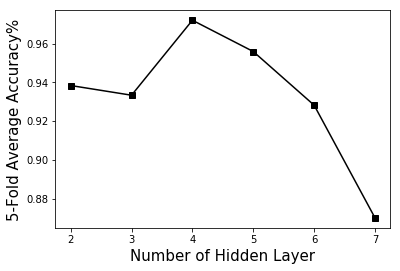

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
k = np.arange(1, 6)
#accuracy = np.random.uniform(96,99,10)
hl = range(2, 8)
avg_accuracy = np.array([0.938347697258, 0.933345866203, 0.972008258, 0.955873370171, 
                         0.928182578087, 0.870076429844])
#plt.set_marker(marker)
plt.plot(hl, avg_accuracy, marker='s', color='black')
plt.ylabel('5-Fold Average Accuracy%', fontsize=15)
plt.xlabel('Number of Hidden Layer', fontsize=15)


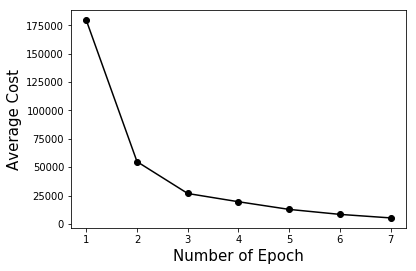

In [17]:
cost = np.array([179474.76082, 54843.78726, 26770.54218, 19502.19456, 12753.41816,
                 8365.23174, 5247.71479])
epoch = np.arange(1, 8)
plt.plot(epoch, cost, marker='o', color='black')
plt.xlabel('Number of Epoch', fontsize=15)
plt.ylabel('Average Cost', fontsize=15)